<a href="https://colab.research.google.com/github/toledotorrespatricio/hjb-nn-mmcc/blob/experiment%2Fjupyter-slscheme-20250619/slscheme-20250611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# VERSIÓN MEJORADA: Con normalización y estabilización numérica
# ============================================================================
import os, datetime, numpy as np, tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

DEVICE = '/GPU:0' if gpus else '/CPU:0'
print("🔧  Usando dispositivo:", DEVICE)

# TensorBoard
log_dir = "logs/slscheme_improved/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir)

with tf.device(DEVICE):
    # -----------------------------------------------------------------------
    # 1) PARÁMETROS DEL SISTEMA
    # -----------------------------------------------------------------------
    C1, C2, C3 = 1_000.0, 5_000.0, 1e-3

    A_mat = tf.constant([[1., 0., .5],
                         [0., 1., .5]], dtype=tf.float32)
    A_pinv = tf.linalg.pinv(A_mat)

    K_mat = tf.constant([[ 2/3, -1/3, -1/3],
                         [-1/3,  2/3, -1/3],
                         [-1/3, -1/3,  2/3]], dtype=tf.float32)

    state_dim, control_dim = 7, 3
    x_min, x_max = 0., 1_000.
    y_min, y_max = -15., 15.
    u_min, u_max = -1., 1.
    λ_w, λ_x, λ_z, λ_u = 0.1, 1, 0.1, 1

    # -----------------------------------------------------------------------
    # NORMALIZACIÓN (CRÍTICO!)
    # -----------------------------------------------------------------------
    # Factores de normalización para llevar todo a [-1, 1]
    x_scale = (x_max - x_min) / 2.0
    x_offset = (x_max + x_min) / 2.0
    y_scale = (y_max - y_min) / 2.0
    y_offset = (y_max + y_min) / 2.0

    @tf.function
    def normalize_state(state):
        """Normaliza estado a [-1, 1]"""
        x, y, z = state[:, :3], state[:, 3:6], state[:, 6:7]
        x_norm = (x - x_offset) / x_scale
        y_norm = (y - y_offset) / y_scale
        z_norm = z / 1000.0  # Normalizar costo acumulado
        return tf.concat([x_norm, y_norm, z_norm], axis=1)

    @tf.function
    def denormalize_state(state_norm):
        """Desnormaliza estado"""
        x_norm, y_norm, z_norm = state_norm[:, :3], state_norm[:, 3:6], state_norm[:, 6:7]
        x = x_norm * x_scale + x_offset
        y = y_norm * y_scale + y_offset
        z = z_norm * 1000.0
        return tf.concat([x, y, z], axis=1)

    # -----------------------------------------------------------------------
    # 2) DISCRETIZACIÓN TEMPORAL
    # -----------------------------------------------------------------------
    T, N, p = 0.5, 1000, 10  # Reducido N para pruebas más rápidas
    dt = T / N

    # -----------------------------------------------------------------------
    # 3) REFERENCIAS
    # -----------------------------------------------------------------------
    @tf.function
    def w_ref(t):
        val = 5.0 * tf.cos(40.0 * np.pi * t)
        return tf.stack([15.0, val], axis=0)[None, :]

    x_ref = tf.constant([[880., 880., 880.]], tf.float32)

    @tf.function
    def d_ref(t):
        val = 300. * tf.cos(40. * np.pi * t)
        return tf.stack([500.0, val], axis=0)[None, :]

    # -----------------------------------------------------------------------
    # 4) DINÁMICA AUMENTADA CON CLIPPING
    # -----------------------------------------------------------------------
    @tf.function
    def f_aug(state, u, t):
        x, y = state[:, :3], state[:, 3:6]

        # Limitar valores para evitar explosión
        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        u = tf.clip_by_value(u, u_min, u_max)

        dx = C1 * y * u

        dvec = tf.repeat(d_ref(t), tf.shape(state)[0], axis=0)
        ATd = tf.matmul(dvec, A_mat)

        Kxu = tf.matmul(x * u, K_mat, transpose_b=True)
        dy = C2 * (-C3 * y + ATd - Kxu)

        # Costos normalizados
        wvec = tf.repeat(w_ref(t), tf.shape(state)[0], axis=0)
        Jw = tf.reduce_sum((tf.matmul(y, A_mat, transpose_b=True) - wvec)**2, 1, keepdims=True) / 100.0
        Jx = tf.reduce_sum((x - tf.repeat(x_ref, tf.shape(state)[0], 0))**2, 1, keepdims=True) / 1e6
        zmat = tf.eye(3) - tf.matmul(A_pinv, A_mat)
        Jz = tf.reduce_sum((tf.matmul(y, zmat, transpose_b=True))**2, 1, keepdims=True) / 100.0
        Ju = tf.reduce_sum((ATd - Kxu)**2, 1, keepdims=True) / 1e6

        Lval = λ_w*Jw + λ_x*Jx + λ_z*Jz + λ_u*Ju

        # Limitar gradientes
        dx = tf.clip_by_value(dx, -1000., 1000.)
        dy = tf.clip_by_value(dy, -100., 100.)
        Lval = tf.clip_by_value(Lval, 0., 100.)

        return tf.concat([dx, dy, Lval], 1)

    # -----------------------------------------------------------------------
    # 5) FUNCIONES AUXILIARES
    # -----------------------------------------------------------------------
    @tf.function
    def g_obstacle(state):
        x, y = state[:, :3], state[:, 3:6]
        vx = tf.maximum(x_min - x, x - x_max)
        vy = tf.maximum(y_min - y, y - y_max)
        violation = tf.maximum(tf.reduce_max(vx, 1), tf.reduce_max(vy, 1))
        return tf.clip_by_value(violation, -10., 10.)  # Limitar penalización

    @tf.function
    def phi_terminal(state):
        return tf.clip_by_value(state[:, 6], 0., 1000.)  # Limitar costo terminal

    def sample_states(batch):
        """Muestreo más inteligente"""
        # 80% cerca del centro, 20% en extremos
        if tf.random.uniform([]) < 0.8:
            x = tf.random.normal([batch, 3], mean=500., stddev=200.)
            y = tf.random.normal([batch, 3], mean=0., stddev=5.)
        else:
            x = tf.random.uniform([batch, 3], x_min, x_max)
            y = tf.random.uniform([batch, 3], y_min, y_max)

        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        z = tf.zeros([batch, 1])
        return tf.concat([x, y, z], 1)

    # -----------------------------------------------------------------------
    # 6) OPERADORES F_a y G_a
    # -----------------------------------------------------------------------
    @tf.function
    def F_a(state, u, t0):
        """Propaga estado - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            t += dt_p
        return s  # Retorna en escala original

    @tf.function
    def G_a(state, u, t0):
        """Calcula violaciones - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        m = tf.zeros([tf.shape(state)[0]])  # Inicializar en 0, no -inf
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            m = tf.maximum(m, g_obstacle(s))
            t += dt_p
        return m

    # -----------------------------------------------------------------------
    # 7) REDES NEURONALES MEJORADAS
    # -----------------------------------------------------------------------
    def create_control_net():
        """Red con regularización y normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(control_dim, activation='tanh')
        ])

    def create_value_net():
        """Red de valor con normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1)
        ])

    # Crear redes
    control_nets = [create_control_net() for _ in range(N)]
    value_nets = [create_value_net() for _ in range(N)]
    value_nets.append(None)

    # Optimizadores con learning rate más conservador
    opt_u = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]
    opt_V = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]

    # -----------------------------------------------------------------------
    # 8) ENTRENAMIENTO MEJORADO
    # -----------------------------------------------------------------------
    epochs_ctrl = 30  # Más épocas
    epochs_val = 30
    bs = 128  # Batch más grande

    # Para early stopping
    patience = 5
    min_delta = 1e-3

    print("🚀 Iniciando entrenamiento mejorado...")

    for n in reversed(range(N)):
        t0 = tf.constant(float(n)*dt, tf.float32)
        print(f"\n=== Paso {n}/{N-1} ===")

        # Entrenar control
        best_loss = float('inf')
        no_improve = 0

        for e in range(1, epochs_ctrl+1):
            S = sample_states(bs)  # Estados en escala original

            with tf.GradientTape() as g:
                u = control_nets[n](S, training=True)  # La red normaliza internamente
                u = tf.clip_by_value(u, u_min, u_max)

                if n + 1 == N:
                    T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
                else:
                    next_state = F_a(S, u, t0)  # Estado en escala original
                    # IMPORTANTE: La red n+1 espera estados originales (se normalizan internamente)
                    next_value = value_nets[n+1](next_state, training=False)
                    T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

                # Añadir pequeña regularización
                T = tf.clip_by_value(T, 0., 1000.)
                loss = tf.reduce_mean(T) + 1e-6 * tf.reduce_sum([tf.nn.l2_loss(w)
                                                                  for w in control_nets[n].trainable_weights])

            grads = g.gradient(loss, control_nets[n].trainable_variables)
            if all(g is not None for g in grads):
                opt_u[n].apply_gradients(zip(grads, control_nets[n].trainable_variables))

            # Early stopping
            if loss < best_loss - min_delta:
                best_loss = loss
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"  Early stopping en época {e}")
                break

            if e % 10 == 0:
                print(f"  ctrl epoch {e} loss {loss.numpy():.6f}")

        # Entrenar valor (similar)
        best_loss_v = float('inf')
        no_improve_v = 0

        for e in range(1, epochs_val+1):
            S = sample_states(bs)
            u = control_nets[n](S, training=False)
            u = tf.clip_by_value(u, u_min, u_max)

            if n + 1 == N:
                T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
            else:
                next_state = F_a(S, u, t0)
                next_value = value_nets[n+1](next_state, training=False)
                T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

            with tf.GradientTape() as gV:
                pred = tf.squeeze(value_nets[n](S, training=True))
                T_clipped = tf.clip_by_value(tf.stop_gradient(T), 0., 1000.)
                lossV = tf.reduce_mean((pred - T_clipped)**2)

            grads_V = gV.gradient(lossV, value_nets[n].trainable_variables)
            if all(g is not None for g in grads_V):
                opt_V[n].apply_gradients(zip(grads_V, value_nets[n].trainable_variables))

            if lossV < best_loss_v - min_delta:
                best_loss_v = lossV
                no_improve_v = 0
            else:
                no_improve_v += 1

            if no_improve_v >= patience:
                print(f"  Early stopping valor en época {e}")
                break

            if e % 10 == 0:
                print(f"  val epoch {e} loss {lossV.numpy():.6f}")

    # -----------------------------------------------------------------------
    # 9) SIMULACIÓN
    # -----------------------------------------------------------------------
    def control_trajectory_SL(x0):
        s = tf.convert_to_tensor(x0[None, :], tf.float32)
        traj, u_seq = [x0.copy()], []
        t = tf.constant(0., tf.float32)

        for n in range(N):
            u = control_nets[n](s, training=False)
            u = tf.clip_by_value(u, u_min, u_max)
            u_seq.append(u.numpy()[0])
            s = F_a(s, u, t)
            traj.append(s.numpy()[0])
            t += dt

        return np.array(traj), np.array(u_seq)

# ============================================================================
# EJEMPLO DE USO
# ============================================================================
x0 = np.array([880., 880., 880., 0., 0., 0., 0.], np.float32)  # Estado inicial más razonable
traj, ctrls = control_trajectory_SL(x0)
print(f"\n✅ Trayectoria: {traj.shape}, Controles: {ctrls.shape}")
print(f"Rango de x: [{traj[:, :3].min():.1f}, {traj[:, :3].max():.1f}]")
print(f"Rango de y: [{traj[:, 3:6].min():.1f}, {traj[:, 3:6].max():.1f}]")
print(f"Costo final: {traj[-1, 6]:.2f}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.

=== Paso 869/999 ===
  Early stopping en época 6
  val epoch 10 loss 0.640101
  val epoch 20 loss 0.647024
  val epoch 30 loss 0.433175

=== Paso 868/999 ===
  Early stopping en época 7
  val epoch 10 loss 0.997925
  val epoch 20 loss 0.535725
  Early stopping valor en época 25

=== Paso 867/999 ===
  Early stopping en época 9
  val epoch 10 loss 1.677560
  val epoch 20 loss 1.087433
  val epoch 30 loss 0.702878

=== Paso 866/999 ===
  Early stopping en época 7
  Early stopping valor en época 7

=== Paso 865/999 ===
  ctrl epoch 10 loss 0.003141
  Early stopping en época 13
  val epoch 10 loss 3.278901
  Early stopping valor en época 12

=== Paso 864/999 ===
  Early stopping en época 7
  Early stopping valor en época 8

=== Paso 863/999 ===
  Early stopping en época 10
  val epoch 10 loss 1.543194
  Early stopping valor en época 20

=== Paso 862/999 ===
  ctrl epoch 10 loss 0.070980
  Early stopping en época 11
  val e

🚀 Ejecutando simulación unificada...
✅ Simulación completada
   Trayectoria: (1001, 7)
   Controles: (1000, 3)
   Puntos finos: (10001, 7)

📊 Generando visualizaciones...

📊 ANÁLISIS DE SEGUIMIENTO DE REFERENCIA:
Error RMS comp. 1: 7.4357
Error RMS comp. 2: 7.1603

📊 ESTADÍSTICAS DE COSTOS (SIN PONDERAR):
Costo  Min          Max          Promedio    
---------------------------------------------
Jw     1.06e-01     2.50e+02     1.07e+02    
Jx     0.00e+00     1.12e+03     3.14e+02    
Jz     0.00e+00     4.59e+01     2.75e+01    
Ju     4.28e+04     2.16e+06     5.01e+05    

📊 PESOS DE PONDERACIÓN (λ):
   λw = 0.1
   λx = 1
   λz = 0.1
   λu = 1

📈 ANÁLISIS DE CONVERGENCIA:
Distancia inicial a x_ref: 0.00
Distancia final a x_ref: 26.53
Costo total acumulado: 0.32


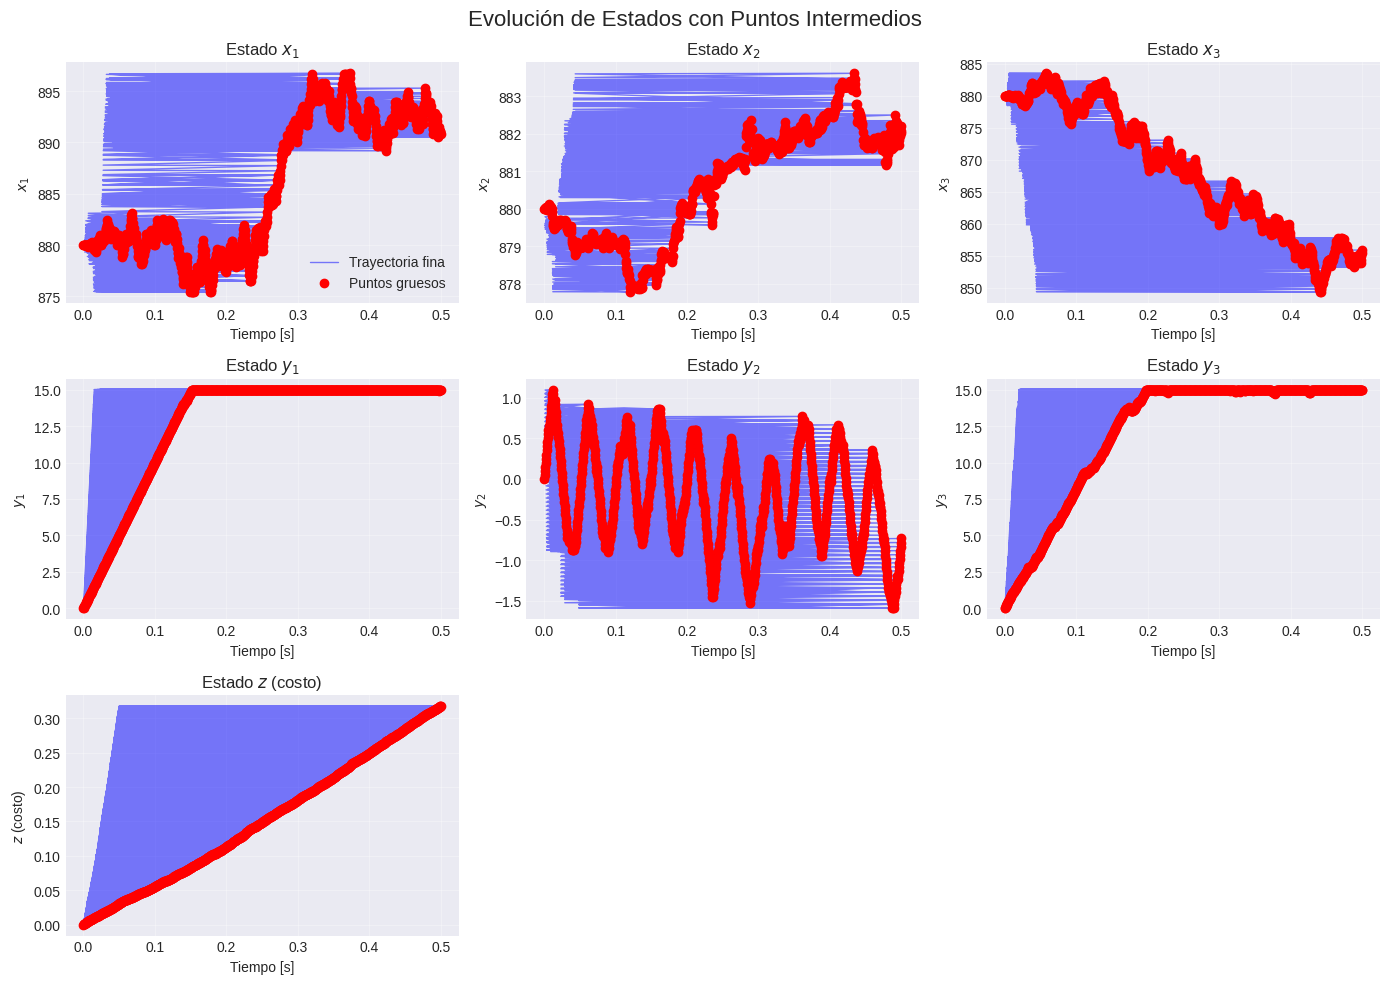

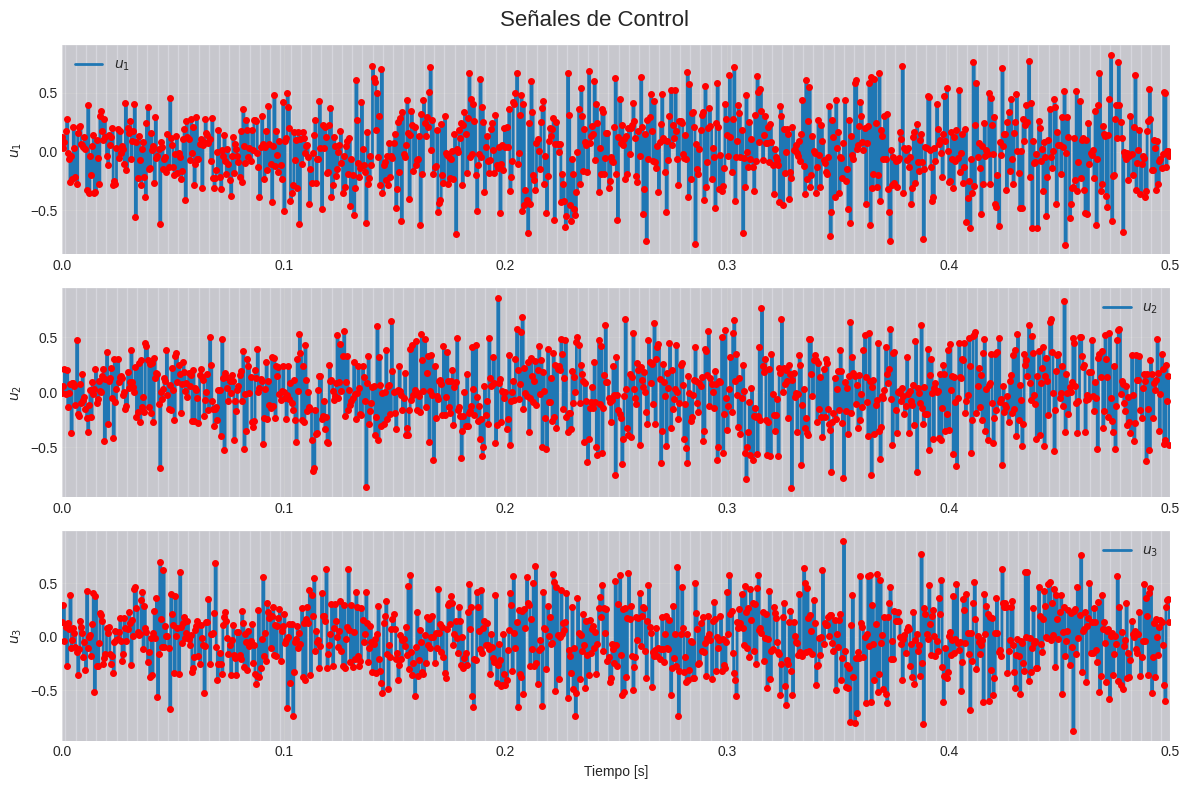

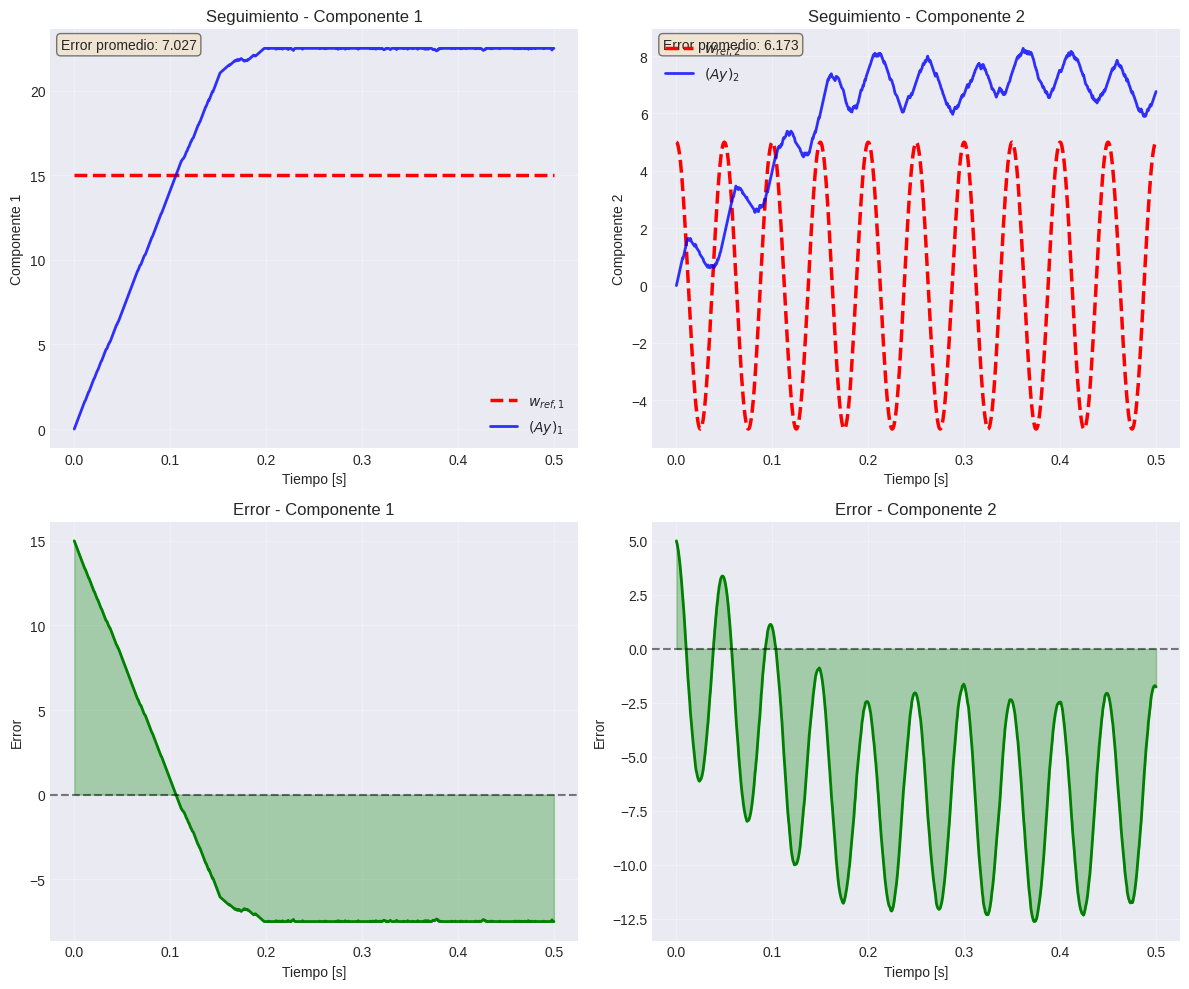

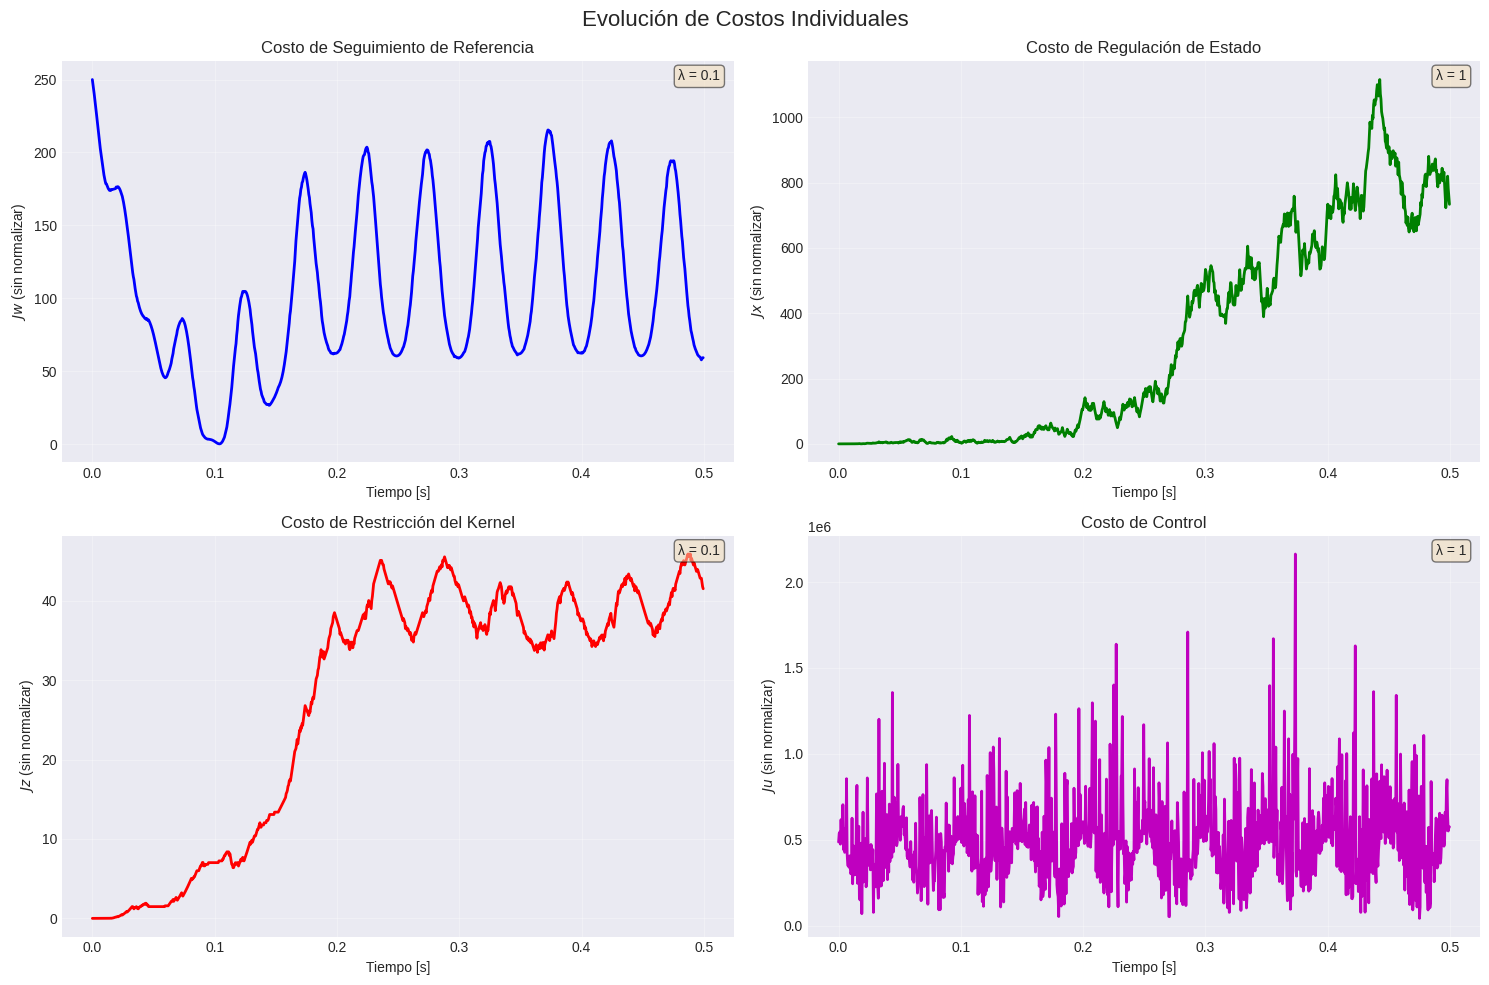

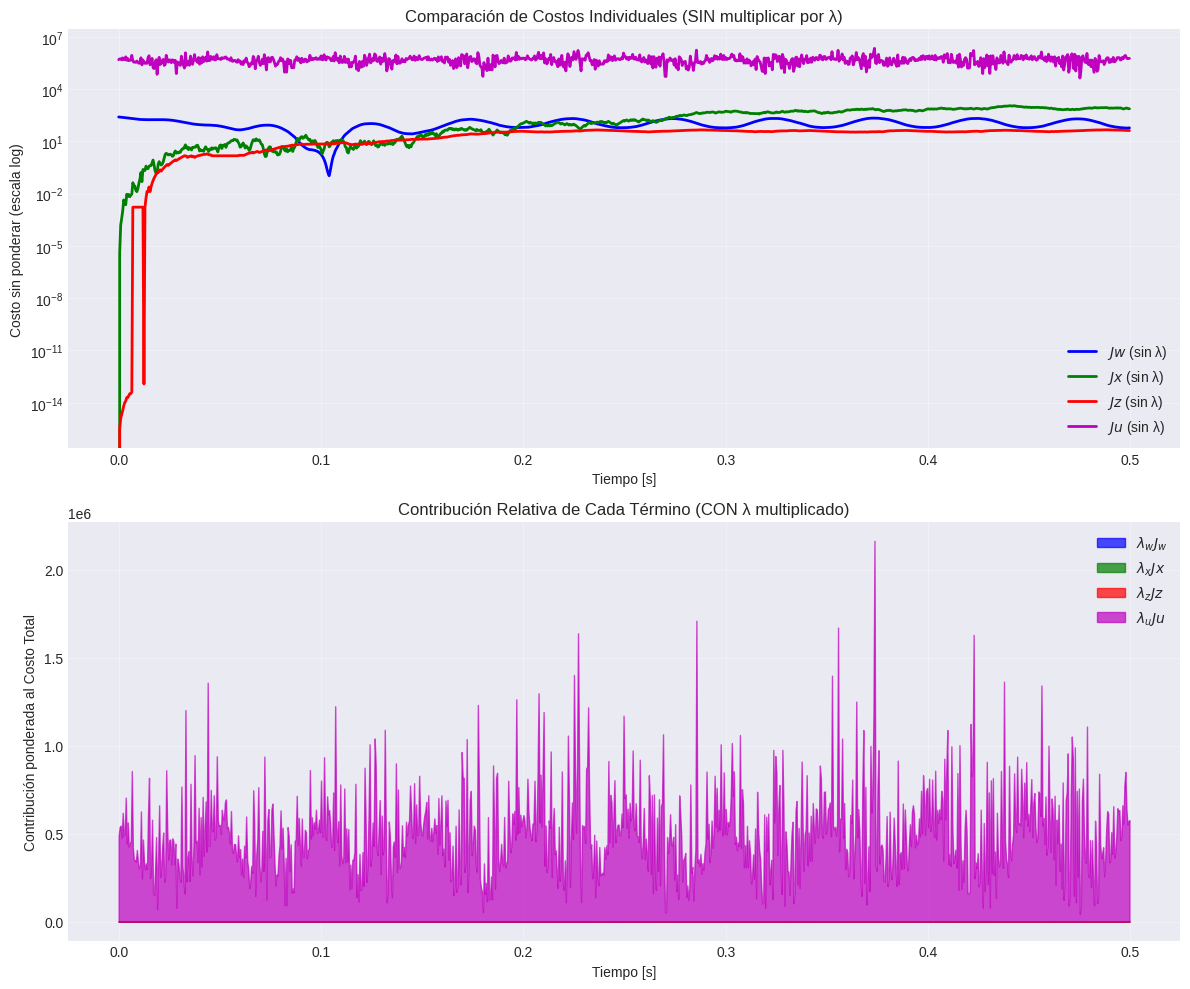

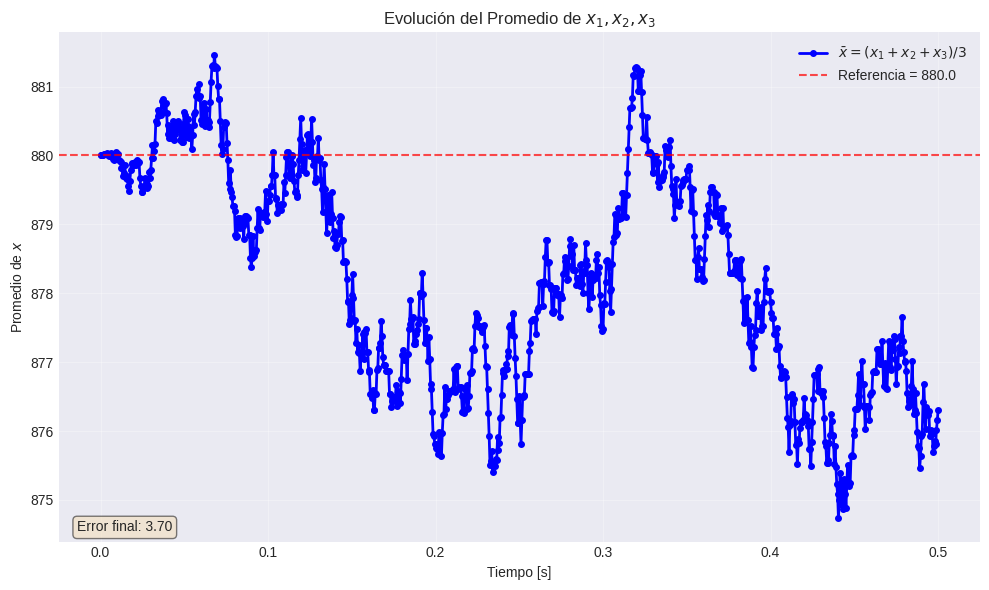

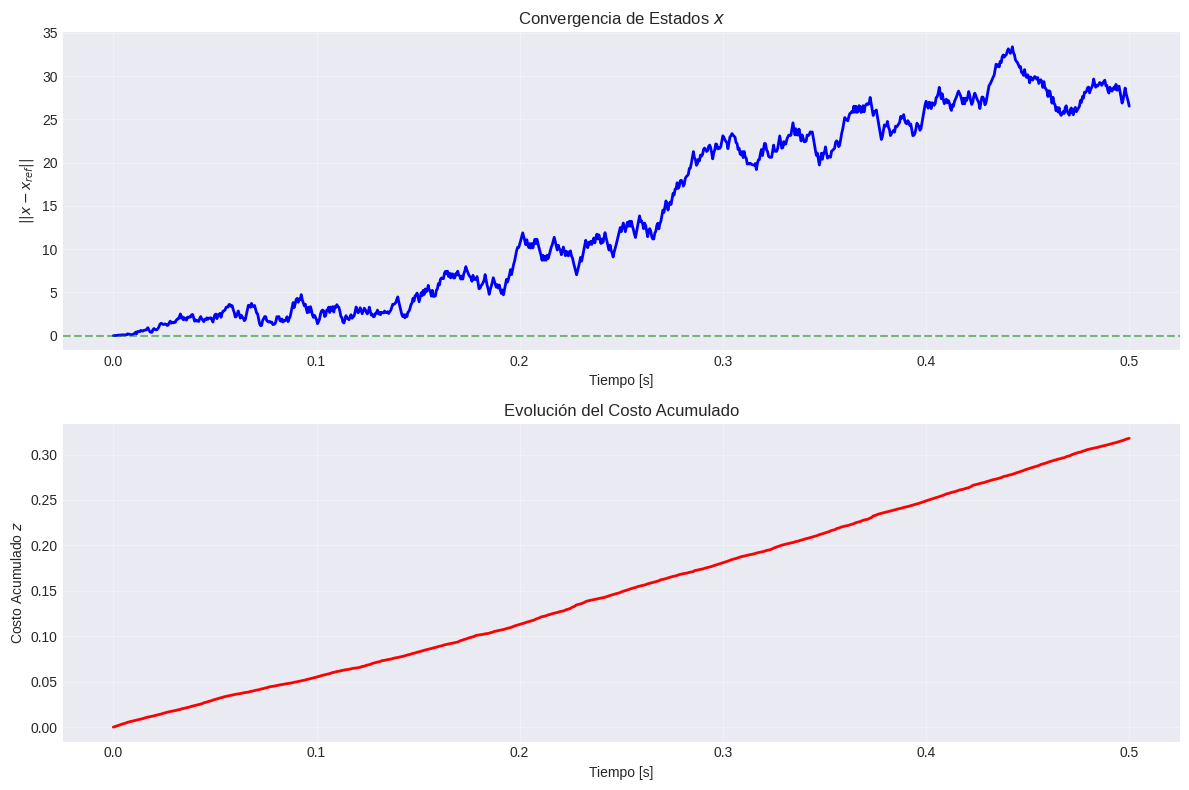

In [8]:
# %%[markdown]
# # Módulo de Visualización para Control SL
# Este notebook contiene funciones optimizadas para visualizar resultados del control

# %%
# ============================================================================
# CELDA 1: IMPORTACIONES Y CONFIGURACIÓN
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d

# Configuración global de estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# %%
# ============================================================================
# CELDA 2: FUNCIONES DE SIMULACIÓN OPTIMIZADAS
# ============================================================================

def simulate_trajectory_with_all_data(x0, control_nets, N, T, p=10,
                                    extract_costs=True, extract_substeps=True):
    """
    Simulación unificada que extrae toda la información necesaria en un solo paso.

    Returns:
        dict con:
        - 'traj': trayectoria en puntos gruesos
        - 'controls': señales de control
        - 'times': tiempos gruesos
        - 'traj_fine': trayectoria fina (si extract_substeps=True)
        - 'times_fine': tiempos finos (si extract_substeps=True)
        - 'costs': diccionario de costos (si extract_costs=True)
    """
    dt = T / N
    dt_p = dt / p

    # Inicialización
    s = tf.convert_to_tensor(x0[None, :], tf.float32)
    results = {
        'traj': [x0.copy()],
        'controls': [],
        'times': [0.0]
    }

    if extract_substeps:
        results['traj_fine'] = [x0.copy()]
        results['times_fine'] = [0.0]

    if extract_costs:
        results['costs'] = {'Jw': [], 'Jx': [], 'Jz': [], 'Ju': [], 'L': []}

    # Simulación principal
    for n in range(N):
        t = tf.constant(n * dt, tf.float32)

        # Control
        u = control_nets[n](s, training=False)
        u = tf.clip_by_value(u, u_min, u_max)
        results['controls'].append(u.numpy()[0])

        # Costos (si se requieren)
        if extract_costs:
            x, y = s[:, :3], s[:, 3:6]

            # Referencias y términos auxiliares
            wvec = tf.repeat(w_ref(t), tf.shape(s)[0], axis=0)
            dvec = tf.repeat(d_ref(t), tf.shape(s)[0], axis=0)
            ATd = tf.matmul(dvec, A_mat)
            Kxu = tf.matmul(x * u, K_mat, transpose_b=True)
            zmat = tf.eye(3) - tf.matmul(A_pinv, A_mat)

            # Costos sin normalizar
            Jw = tf.reduce_sum((tf.matmul(y, A_mat, transpose_b=True) - wvec)**2, 1, keepdims=True)
            Jx = tf.reduce_sum((x - tf.repeat(x_ref, tf.shape(s)[0], 0))**2, 1, keepdims=True)
            Jz = tf.reduce_sum((tf.matmul(y, zmat, transpose_b=True))**2, 1, keepdims=True)
            Ju = tf.reduce_sum((ATd - Kxu)**2, 1, keepdims=True)
            L = λ_w*Jw + λ_x*Jx + λ_z*Jz + λ_u*Ju

            results['costs']['Jw'].append(Jw.numpy()[0, 0])
            results['costs']['Jx'].append(Jx.numpy()[0, 0])
            results['costs']['Jz'].append(Jz.numpy()[0, 0])
            results['costs']['Ju'].append(Ju.numpy()[0, 0])
            results['costs']['L'].append(L.numpy()[0, 0])

        # Propagación con sub-pasos
        s_temp = s
        t_temp = t

        for i in range(p):
            # Actualización
            ds = f_aug(s_temp, u, t_temp)
            s_temp = s_temp + dt_p * ds[:, :7]
            s_temp = tf.concat([
                tf.clip_by_value(s_temp[:, :3], x_min, x_max),
                tf.clip_by_value(s_temp[:, 3:6], y_min, y_max),
                s_temp[:, 6:]
            ], 1)

            # Guardar sub-paso si se requiere
            if extract_substeps and i < p - 1:
                results['traj_fine'].append(s_temp.numpy()[0])
                results['times_fine'].append((n + 1) * dt * (i + 1) / p)

            t_temp += dt_p

        # Actualizar estado y tiempo
        s = s_temp
        results['traj'].append(s.numpy()[0])
        results['times'].append((n + 1) * dt)

        if extract_substeps:
            results['traj_fine'].append(s.numpy()[0])
            results['times_fine'].append((n + 1) * dt)

    # Convertir a arrays
    for key in ['traj', 'controls', 'times']:
        if key in results:
            results[key] = np.array(results[key])

    if extract_substeps:
        results['traj_fine'] = np.array(results['traj_fine'])
        results['times_fine'] = np.array(results['times_fine'])

    if extract_costs:
        for key in results['costs']:
            results['costs'][key] = np.array(results['costs'][key])

    return results

# %%
# ============================================================================
# CELDA 3: FUNCIONES DE VISUALIZACIÓN - TRAYECTORIAS
# ============================================================================

def plot_states_with_substeps(sim_data, figsize=(14, 10)):
    """Grafica estados con puntos intermedios"""
    traj = sim_data['traj']
    traj_fine = sim_data.get('traj_fine', traj)
    times = sim_data['times']
    times_fine = sim_data.get('times_fine', times)

    fig, axes = plt.subplots(3, 3, figsize=figsize)
    fig.suptitle('Evolución de Estados con Puntos Intermedios', fontsize=16)

    labels = ['$x_1$', '$x_2$', '$x_3$', '$y_1$', '$y_2$', '$y_3$', '$z$ (costo)']

    for i in range(7):
        row, col = i // 3, i % 3
        ax = axes[row, col]

        # Trayectoria fina
        ax.plot(times_fine, traj_fine[:, i], '-', color='blue',
                alpha=0.5, linewidth=1, label='Trayectoria fina')

        # Puntos gruesos
        ax.plot(times, traj[:, i], 'o', color='red',
                markersize=6, label='Puntos gruesos')

        ax.set_xlabel('Tiempo [s]')
        ax.set_ylabel(labels[i])
        ax.set_title(f'Estado {labels[i]}')
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.legend()

    # Eliminar subplots vacíos
    for i in range(7, 9):
        fig.delaxes(axes[2, i-6])

    plt.tight_layout()
    return fig

def plot_controls(sim_data, figsize=(12, 8)):
    """Grafica controles como señales escalonadas"""
    controls = sim_data['controls']
    times = sim_data['times'][:-1]  # N tiempos para N controles
    T = sim_data['times'][-1]

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle('Señales de Control', fontsize=16)

    labels = ['$u_1$', '$u_2$', '$u_3$']

    for i in range(3):
        ax = axes[i]
        ax.step(times, controls[:, i], where='post', linewidth=2, label=labels[i])
        ax.plot(times, controls[:, i], 'ro', markersize=4)

        # Sombrear regiones
        for j in range(len(times)):
            t_end = times[j+1] if j+1 < len(times) else T
            ax.axvspan(times[j], t_end, alpha=0.1, color='gray')

        ax.set_ylabel(labels[i])
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xlim([0, T])

    axes[-1].set_xlabel('Tiempo [s]')
    plt.tight_layout()
    return fig

# %%
# ============================================================================
# CELDA 4: FUNCIONES DE VISUALIZACIÓN - SEGUIMIENTO DE REFERENCIA
# ============================================================================

def plot_reference_tracking(sim_data, figsize=(12, 10)):
    """Grafica seguimiento de referencia w_ref vs A*y"""
    traj = sim_data['traj']
    times = sim_data['times']

    # Calcular A*y
    y_traj = traj[:, 3:6]
    Ay_traj = np.array([A_mat.numpy() @ y_traj[i] for i in range(len(traj))])

    # Calcular w_ref
    w_ref_traj = np.array([w_ref(tf.constant(t, tf.float32)).numpy()[0] for t in times])

    # Crear gráficos
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Componente 1
    ax1 = axes[0, 0]
    ax1.plot(times, w_ref_traj[:, 0], 'r--', linewidth=2.5, label='$w_{ref,1}$')
    ax1.plot(times, Ay_traj[:, 0], 'b-', linewidth=2, label='$(Ay)_1$', alpha=0.8)
    ax1.set_xlabel('Tiempo [s]')
    ax1.set_ylabel('Componente 1')
    ax1.set_title('Seguimiento - Componente 1')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    error1 = np.mean(np.abs(w_ref_traj[:, 0] - Ay_traj[:, 0]))
    ax1.text(0.02, 0.98, f'Error promedio: {error1:.3f}',
             transform=ax1.transAxes, va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Componente 2
    ax2 = axes[0, 1]
    ax2.plot(times, w_ref_traj[:, 1], 'r--', linewidth=2.5, label='$w_{ref,2}$')
    ax2.plot(times, Ay_traj[:, 1], 'b-', linewidth=2, label='$(Ay)_2$', alpha=0.8)
    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Componente 2')
    ax2.set_title('Seguimiento - Componente 2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    error2 = np.mean(np.abs(w_ref_traj[:, 1] - Ay_traj[:, 1]))
    ax2.text(0.02, 0.98, f'Error promedio: {error2:.3f}',
             transform=ax2.transAxes, va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Error temporal
    error_traj = w_ref_traj - Ay_traj

    ax3 = axes[1, 0]
    ax3.plot(times, error_traj[:, 0], 'g-', linewidth=2)
    ax3.fill_between(times, error_traj[:, 0], 0, alpha=0.3, color='green')
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Tiempo [s]')
    ax3.set_ylabel('Error')
    ax3.set_title('Error - Componente 1')
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    ax4.plot(times, error_traj[:, 1], 'g-', linewidth=2)
    ax4.fill_between(times, error_traj[:, 1], 0, alpha=0.3, color='green')
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Tiempo [s]')
    ax4.set_ylabel('Error')
    ax4.set_title('Error - Componente 2')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Imprimir estadísticas
    print("\n📊 ANÁLISIS DE SEGUIMIENTO DE REFERENCIA:")
    print(f"Error RMS comp. 1: {np.sqrt(np.mean(error_traj[:, 0]**2)):.4f}")
    print(f"Error RMS comp. 2: {np.sqrt(np.mean(error_traj[:, 1]**2)):.4f}")

    return fig, {'Ay': Ay_traj, 'w_ref': w_ref_traj, 'error': error_traj}

# %%
# ============================================================================
# CELDA 5: FUNCIONES DE VISUALIZACIÓN - COSTOS
# ============================================================================

def plot_costs_evolution(sim_data, figsize=(15, 10), show_weighted_in_log=False):
    """
    Visualiza evolución temporal de costos

    Args:
        sim_data: Datos de simulación
        figsize: Tamaño de figura
        show_weighted_in_log: Si True, muestra costos ponderados (λ*J) en escala log,
                             si False, muestra costos sin ponderar (J)
    """
    if 'costs' not in sim_data:
        print("⚠️ No hay datos de costos en la simulación")
        return None

    costs = sim_data['costs']
    times = sim_data['times'][:-1]  # N tiempos para N costos

    # Figura 1: Costos individuales
    fig1, axes = plt.subplots(2, 2, figsize=figsize)
    fig1.suptitle('Evolución de Costos Individuales', fontsize=16)

    # Configuración de cada subplot
    configs = [
        ('Jw', 'b', 'Seguimiento de Referencia', λ_w),
        ('Jx', 'g', 'Regulación de Estado', λ_x),
        ('Jz', 'r', 'Restricción del Kernel', λ_z),
        ('Ju', 'm', 'Control', λ_u)
    ]

    for idx, (key, color, title, lam) in enumerate(configs):
        ax = axes[idx//2, idx%2]
        ax.plot(times, costs[key], color=color, linewidth=2)
        ax.set_xlabel('Tiempo [s]')
        ax.set_ylabel(f'${key}$ (sin normalizar)')
        ax.set_title(f'Costo de {title}')
        ax.grid(True, alpha=0.3)
        ax.text(0.98, 0.98, f'λ = {lam}', transform=ax.transAxes,
                ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    # Figura 2: Comparación logarítmica y contribuciones
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Escala logarítmica - COSTOS SIN PONDERAR
    for key, color, _, lam in configs:
        if show_weighted_in_log:
            ax1.semilogy(times, lam * costs[key], color=color, linewidth=2,
                         label=f'$\\lambda_{key[1]} {key}$ (λ={lam})')
        else:
            ax1.semilogy(times, costs[key], color=color, linewidth=2,
                         label=f'${key}$ (sin λ)')

    ax1.set_xlabel('Tiempo [s]')
    if show_weighted_in_log:
        ax1.set_ylabel('Costo ponderado (escala log)')
        ax1.set_title('Comparación de Costos Ponderados (λ*J) - Escala Logarítmica')
    else:
        ax1.set_ylabel('Costo sin ponderar (escala log)')
        ax1.set_title('Comparación de Costos Individuales (SIN multiplicar por λ)')
    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both')

    # Contribuciones relativas
    contribs = {}
    for key, _, _, lam in configs:
        contribs[key] = lam * costs[key]

    # Gráfico de áreas apiladas
    ax2.fill_between(times, 0, contribs['Jw'],
                     label='$\\lambda_w J_w$', alpha=0.7, color='blue')
    bottom = contribs['Jw']

    for key, color, _, _ in configs[1:]:
        ax2.fill_between(times, bottom, bottom + contribs[key],
                        label=f'$\\lambda_{key[1]} {key}$', alpha=0.7, color=color)
        bottom += contribs[key]

    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Contribución ponderada al Costo Total')
    ax2.set_title('Contribución Relativa de Cada Término (CON λ multiplicado)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Imprimir estadísticas
    print("\n📊 ESTADÍSTICAS DE COSTOS (SIN PONDERAR):")
    print(f"{'Costo':<6} {'Min':<12} {'Max':<12} {'Promedio':<12}")
    print("-" * 45)
    for key in ['Jw', 'Jx', 'Jz', 'Ju']:
        data = costs[key]
        print(f"{key:<6} {np.min(data):<12.2e} {np.max(data):<12.2e} "
              f"{np.mean(data):<12.2e}")

    print("\n📊 PESOS DE PONDERACIÓN (λ):")
    print(f"   λw = {λ_w}")
    print(f"   λx = {λ_x}")
    print(f"   λz = {λ_z}")
    print(f"   λu = {λ_u}")

    return fig1, fig2

# %%
# ============================================================================
# CELDA 6: FUNCIONES DE ANÁLISIS ADICIONALES
# ============================================================================

def plot_mean_x_evolution(sim_data, figsize=(10, 6)):
    """Grafica evolución del promedio de x1, x2, x3"""
    traj = sim_data['traj']
    times = sim_data['times']

    # Calcular promedio
    x_mean = np.mean(traj[:, :3], axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(times, x_mean, 'b-', linewidth=2, marker='o', markersize=4,
            label='$\\bar{x} = (x_1 + x_2 + x_3)/3$')

    # Referencia
    x_ref_mean = 880.0  # Promedio de la referencia
    ax.axhline(y=x_ref_mean, color='r', linestyle='--', alpha=0.7,
               label=f'Referencia = {x_ref_mean}')

    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Promedio de $x$')
    ax.set_title('Evolución del Promedio de $x_1, x_2, x_3$')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Agregar información
    error_final = abs(x_mean[-1] - x_ref_mean)
    ax.text(0.02, 0.02, f'Error final: {error_final:.2f}',
            transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    return fig

def plot_convergence_analysis(sim_data, figsize=(12, 8)):
    """Análisis de convergencia al objetivo"""
    traj = sim_data['traj']
    times = sim_data['times']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Distancia al objetivo para x
    x_ref_val = 880.0
    distances_x = np.sqrt(np.sum((traj[:, :3] - x_ref_val)**2, axis=1))

    ax1.plot(times, distances_x, 'b-', linewidth=2)
    ax1.axhline(y=0, color='g', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Tiempo [s]')
    ax1.set_ylabel('$||x - x_{ref}||$')
    ax1.set_title('Convergencia de Estados $x$')
    ax1.grid(True, alpha=0.3)

    # Costo acumulado
    ax2.plot(times, traj[:, 6], 'r-', linewidth=2)
    ax2.set_xlabel('Tiempo [s]')
    ax2.set_ylabel('Costo Acumulado $z$')
    ax2.set_title('Evolución del Costo Acumulado')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Imprimir resumen
    print(f"\n📈 ANÁLISIS DE CONVERGENCIA:")
    print(f"Distancia inicial a x_ref: {distances_x[0]:.2f}")
    print(f"Distancia final a x_ref: {distances_x[-1]:.2f}")
    print(f"Costo total acumulado: {traj[-1, 6]:.2f}")

    return fig

# %%
# ============================================================================
# CELDA 7: FUNCIÓN PRINCIPAL DE VISUALIZACIÓN
# ============================================================================

def visualize_all_results(x0, control_nets, N, T, p=10,
                         plot_substeps=True, plot_costs=True,
                         show_weighted_costs=False):
    """
    Función principal que ejecuta la simulación y genera todas las visualizaciones.

    Args:
        x0: Estado inicial
        control_nets: Lista de redes de control
        N: Número de pasos
        T: Tiempo total
        p: Subdivisiones por paso
        plot_substeps: Si graficar puntos intermedios
        plot_costs: Si graficar evolución de costos
        show_weighted_costs: Si mostrar costos ponderados (λ*J) en escala log

    Returns:
        sim_data: Diccionario con todos los datos de simulación
        figs: Diccionario con todas las figuras generadas
    """
    print("🚀 Ejecutando simulación unificada...")

    # Simulación con todos los datos
    sim_data = simulate_trajectory_with_all_data(
        x0, control_nets, N, T, p,
        extract_costs=plot_costs,
        extract_substeps=plot_substeps
    )

    print(f"✅ Simulación completada")
    print(f"   Trayectoria: {sim_data['traj'].shape}")
    print(f"   Controles: {sim_data['controls'].shape}")
    if plot_substeps:
        print(f"   Puntos finos: {sim_data['traj_fine'].shape}")

    # Generar visualizaciones
    figs = {}

    print("\n📊 Generando visualizaciones...")

    # 1. Estados y controles
    if plot_substeps:
        figs['states'] = plot_states_with_substeps(sim_data)
    figs['controls'] = plot_controls(sim_data)

    # 2. Seguimiento de referencia
    figs['tracking'], tracking_data = plot_reference_tracking(sim_data)

    # 3. Evolución de costos
    if plot_costs:
        fig_costs1, fig_costs2 = plot_costs_evolution(
            sim_data, show_weighted_in_log=show_weighted_costs
        )
        figs['costs_individual'] = fig_costs1
        figs['costs_comparison'] = fig_costs2

    # 4. Análisis adicionales
    figs['mean_x'] = plot_mean_x_evolution(sim_data)
    figs['convergence'] = plot_convergence_analysis(sim_data)

    plt.show()

    return sim_data, figs

# %%
# ============================================================================
# CELDA 8: EJEMPLO DE USO
# ============================================================================

# Estado inicial
x0 = np.array([880., 880., 880., 0., 0., 0., 0.], np.float32)

# Ejecutar visualización completa
# show_weighted_costs=False muestra costos sin ponderar (J) en escala log
# show_weighted_costs=True muestra costos ponderados (λ*J) en escala log
sim_data, figs = visualize_all_results(
    x0, control_nets, N, T, p=10,
    plot_substeps=True,
    plot_costs=True,
    show_weighted_costs=False  # Cambiar a True para ver costos ponderados
)

# NOTA SOBRE LOS GRÁFICOS DE COSTOS:
# - Gráfico 1 (4 subplots): Siempre muestra costos SIN ponderar (J)
# - Gráfico 2 superior (escala log): Muestra J o λ*J según show_weighted_costs
# - Gráfico 2 inferior (áreas apiladas): Siempre muestra costos ponderados (λ*J)

# %%
# ============================================================================
# CELDA 9: GUARDAR FIGURAS (OPCIONAL)
# ============================================================================

def save_all_figures(figs, base_dir="figures", dpi=300):
    """Guarda todas las figuras generadas"""
    import os
    os.makedirs(base_dir, exist_ok=True)

    for name, fig in figs.items():
        if fig is not None:
            filepath = os.path.join(base_dir, f"{name}.png")
            fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
            print(f"✅ Guardado: {filepath}")

# Descomentar para guardar
# save_all_figures(figs)

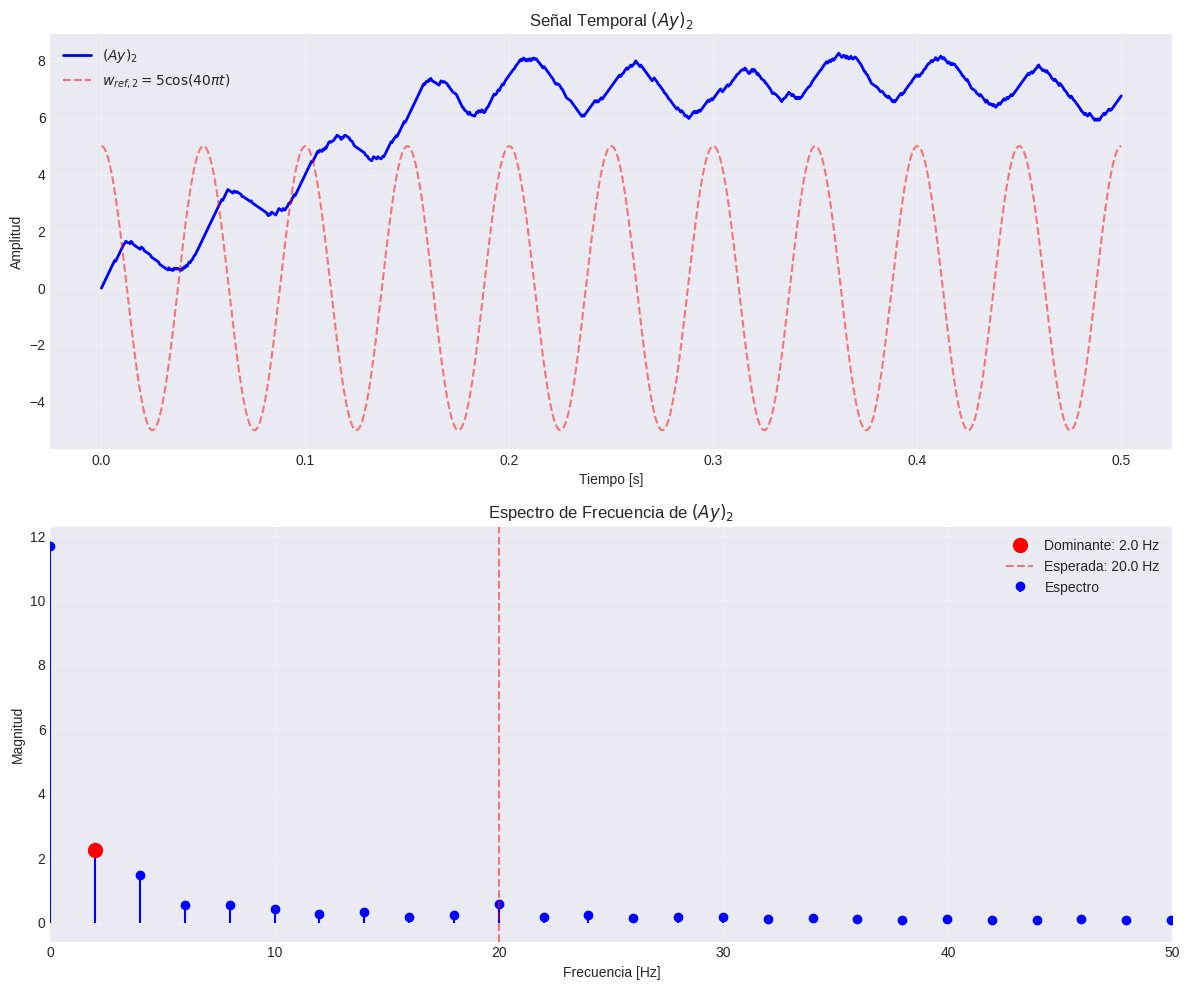


🔍 ANÁLISIS DE FRECUENCIA DE (Ay)₂:
Frecuencia de muestreo: 2000.0 Hz
Frecuencia de Nyquist: 1000.0 Hz
Número de muestras: 1001

📊 FRECUENCIA DOMINANTE:
  Frecuencia: 2.00 Hz
  Período: 0.5005 s
  Magnitud: 2.2671

📊 FRECUENCIA ESPERADA (referencia):
  Frecuencia: 20.00 Hz (40π rad/s)
  Error: 18.00 Hz (90.0%)

📊 ENERGÍA POR BANDAS:
  DC (0 Hz): 93.8%
  Baja (1-10 Hz): 5.6%
  Media (10-30 Hz): 0.5%
  Alta (30-50 Hz): 0.1%

📊 POSIBLES ARMÓNICOS:
  2° armónico (4.0 Hz): Magnitud = 1.4931
  3° armónico (6.0 Hz): Magnitud = 0.5482
  4° armónico (8.0 Hz): Magnitud = 0.5500
⚠️ No se detectaron picos claros en la autocorrelación

Frecuencia de (Ay)₂: 2.00 Hz


In [9]:
# %%
# ============================================================================
# ANÁLISIS DE FRECUENCIA DE Ay_2
# ============================================================================

import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def analyze_frequency_Ay2(sim_data, plot=True):
    """
    Analiza la frecuencia dominante de la segunda componente de A*y

    Args:
        sim_data: Datos de simulación con trayectoria
        plot: Si generar gráfico del espectro

    Returns:
        dict con:
        - dominant_freq: Frecuencia dominante en Hz
        - magnitude: Magnitud en la frecuencia dominante
        - spectrum: Espectro completo
        - frequencies: Vector de frecuencias
    """
    # Extraer datos
    traj = sim_data['traj']
    times = sim_data['times']

    # Calcular A*y
    y_traj = traj[:, 3:6]
    Ay_traj = np.array([A_mat.numpy() @ y_traj[i] for i in range(len(traj))])

    # Segunda componente de A*y
    Ay2 = Ay_traj[:, 1]

    # Parámetros de muestreo
    dt = times[1] - times[0]  # Paso de tiempo
    fs = 1/dt  # Frecuencia de muestreo
    n_samples = len(Ay2)

    # FFT
    yf = fft(Ay2)
    xf = fftfreq(n_samples, dt)[:n_samples//2]

    # Espectro de magnitud (solo frecuencias positivas)
    magnitude = 2.0/n_samples * np.abs(yf[:n_samples//2])

    # Encontrar picos en el espectro
    peaks, properties = find_peaks(magnitude, height=0.1*np.max(magnitude))

    # Frecuencia dominante
    if len(peaks) > 0:
        dominant_idx = peaks[np.argmax(properties['peak_heights'])]
        dominant_freq = xf[dominant_idx]
        dominant_mag = magnitude[dominant_idx]
    else:
        # Si no hay picos claros, tomar el máximo
        dominant_idx = np.argmax(magnitude[1:]) + 1  # Ignorar DC
        dominant_freq = xf[dominant_idx]
        dominant_mag = magnitude[dominant_idx]

    # Análisis adicional
    # Calcular energía en bandas de frecuencia
    freq_bands = {
        'DC (0 Hz)': (0, 1),
        'Baja (1-10 Hz)': (1, 10),
        'Media (10-30 Hz)': (10, 30),
        'Alta (30-50 Hz)': (30, 50)
    }

    band_energy = {}
    for band_name, (f_low, f_high) in freq_bands.items():
        mask = (xf >= f_low) & (xf <= f_high)
        band_energy[band_name] = np.sum(magnitude[mask]**2)

    # Gráfico si se solicita
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Señal temporal
        ax1.plot(times, Ay2, 'b-', linewidth=2, label='$(Ay)_2$')

        # Superponer referencia esperada para comparación
        w_ref2 = 5 * np.cos(40 * np.pi * times)
        ax1.plot(times, w_ref2, 'r--', alpha=0.5, label='$w_{ref,2} = 5\\cos(40\\pi t)$')

        ax1.set_xlabel('Tiempo [s]')
        ax1.set_ylabel('Amplitud')
        ax1.set_title('Señal Temporal $(Ay)_2$')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Espectro de frecuencia
        ax2.stem(xf, magnitude, 'b-', basefmt=' ', markerfmt='bo', label='Espectro')

        # Marcar frecuencia dominante
        ax2.plot(dominant_freq, dominant_mag, 'ro', markersize=10,
                 label=f'Dominante: {dominant_freq:.1f} Hz')

        # Marcar frecuencia esperada (20 Hz = 40π/(2π))
        expected_freq = 20.0
        ax2.axvline(x=expected_freq, color='r', linestyle='--', alpha=0.5,
                    label=f'Esperada: {expected_freq} Hz')

        # Marcar todos los picos encontrados
        if len(peaks) > 0:
            ax2.plot(xf[peaks], magnitude[peaks], 'go', markersize=6,
                     alpha=0.7, label='Picos detectados')

        ax2.set_xlabel('Frecuencia [Hz]')
        ax2.set_ylabel('Magnitud')
        ax2.set_title('Espectro de Frecuencia de $(Ay)_2$')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, min(50, fs/2))  # Limitar a 50 Hz o Nyquist

        plt.tight_layout()
        plt.show()

    # Imprimir resultados
    print("\n🔍 ANÁLISIS DE FRECUENCIA DE (Ay)₂:")
    print(f"{'='*50}")
    print(f"Frecuencia de muestreo: {fs:.1f} Hz")
    print(f"Frecuencia de Nyquist: {fs/2:.1f} Hz")
    print(f"Número de muestras: {n_samples}")
    print(f"\n📊 FRECUENCIA DOMINANTE:")
    print(f"  Frecuencia: {dominant_freq:.2f} Hz")
    print(f"  Período: {1/dominant_freq:.4f} s")
    print(f"  Magnitud: {dominant_mag:.4f}")
    print(f"\n📊 FRECUENCIA ESPERADA (referencia):")
    print(f"  Frecuencia: 20.00 Hz (40π rad/s)")
    print(f"  Error: {abs(dominant_freq - 20.0):.2f} Hz ({abs(dominant_freq - 20.0)/20.0*100:.1f}%)")

    print(f"\n📊 ENERGÍA POR BANDAS:")
    total_energy = sum(band_energy.values())
    for band, energy in band_energy.items():
        percentage = (energy/total_energy)*100 if total_energy > 0 else 0
        print(f"  {band}: {percentage:.1f}%")

    # Encontrar armónicos si existen
    if dominant_freq > 0:
        print(f"\n📊 POSIBLES ARMÓNICOS:")
        for n in range(2, 5):
            harmonic_freq = n * dominant_freq
            if harmonic_freq < fs/2:  # Solo si está bajo Nyquist
                # Buscar pico cerca del armónico
                idx = np.argmin(np.abs(xf - harmonic_freq))
                if idx in peaks or magnitude[idx] > 0.05*dominant_mag:
                    print(f"  {n}° armónico ({harmonic_freq:.1f} Hz): "
                          f"Magnitud = {magnitude[idx]:.4f}")

    return {
        'dominant_freq': dominant_freq,
        'magnitude': dominant_mag,
        'spectrum': magnitude,
        'frequencies': xf,
        'peaks': peaks,
        'Ay2': Ay2
    }

# %%
# ============================================================================
# MÉTODO ALTERNATIVO: AUTOCORRELACIÓN
# ============================================================================

def find_frequency_autocorrelation(sim_data):
    """
    Encuentra la frecuencia usando autocorrelación (útil para señales ruidosas)
    """
    # Extraer Ay2
    traj = sim_data['traj']
    times = sim_data['times']
    y_traj = traj[:, 3:6]
    Ay_traj = np.array([A_mat.numpy() @ y_traj[i] for i in range(len(traj))])
    Ay2 = Ay_traj[:, 1]

    # Remover media
    Ay2_centered = Ay2 - np.mean(Ay2)

    # Autocorrelación
    autocorr = np.correlate(Ay2_centered, Ay2_centered, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # Solo parte positiva
    autocorr = autocorr / autocorr[0]  # Normalizar

    # Encontrar picos en autocorrelación
    peaks, _ = find_peaks(autocorr, height=0.3)

    if len(peaks) > 0:
        # Primer pico indica el período
        dt = times[1] - times[0]
        period = peaks[0] * dt
        frequency = 1 / period

        print(f"\n🔍 ANÁLISIS POR AUTOCORRELACIÓN:")
        print(f"  Período detectado: {period:.4f} s")
        print(f"  Frecuencia: {frequency:.2f} Hz")

        return frequency
    else:
        print("⚠️ No se detectaron picos claros en la autocorrelación")
        return None

# %%
# ============================================================================
# USO DE LAS FUNCIONES
# ============================================================================

# Asumiendo que ya tienes sim_data de la simulación
# Si no, ejecuta primero:
# sim_data, figs = visualize_all_results(x0, control_nets, N, T)

# Método 1: FFT completo con visualización
freq_analysis = analyze_frequency_Ay2(sim_data, plot=True)

# Método 2: Autocorrelación (más robusto para señales ruidosas)
freq_autocorr = find_frequency_autocorrelation(sim_data)

# %%
# ============================================================================
# FUNCIÓN SIMPLIFICADA SOLO PARA OBTENER LA FRECUENCIA
# ============================================================================

def get_Ay2_frequency(sim_data):
    """
    Función simple que solo retorna la frecuencia dominante de Ay2

    Returns:
        float: Frecuencia dominante en Hz
    """
    # Calcular Ay
    traj = sim_data['traj']
    y_traj = traj[:, 3:6]
    Ay_traj = np.array([A_mat.numpy() @ y_traj[i] for i in range(len(traj))])
    Ay2 = Ay_traj[:, 1]

    # FFT
    dt = sim_data['times'][1] - sim_data['times'][0]
    n = len(Ay2)
    yf = fft(Ay2)
    xf = fftfreq(n, dt)[:n//2]
    magnitude = 2.0/n * np.abs(yf[:n//2])

    # Ignorar DC y encontrar máximo
    dominant_idx = np.argmax(magnitude[1:]) + 1
    dominant_freq = xf[dominant_idx]

    return dominant_freq

# Uso simple:
freq = get_Ay2_frequency(sim_data)
print(f"\nFrecuencia de (Ay)₂: {freq:.2f} Hz")